In [46]:
import numpy as np
from PIL import Image
from pathlib import Path
from multiprocessing import cpu_count, Pool
from tqdm.autonotebook import tqdm
from hashlib import md5

In [89]:
files = list(Path("../data/meta/masks_overlayed_eroded_0_dilated_0/train/masks").glob("*.png"))

In [90]:
def get_shard(path):
    return md5(path.stem.encode()).hexdigest()[:2]

In [91]:
def convert_single(args):
    path, target_dir = args
    try:
        image = np.asarray(Image.open(path)) / 255.0
        mask = Image.fromarray(np.uint8((image > 0) * 255) , 'L')
        shard = get_shard(path)
        (target_dir / shard).mkdir(exist_ok=True)
        mask.save(str(target_dir / shard / path.name))
        return True, None
    except Exception as ex:
        return False, ex

In [92]:
with Pool(cpu_count()) as pool:
    cnt = len(files)
    target_dir = Path("/media/marcin/Data/Dev/poc_rooftop_seg/notebooks/neptuneai-mapping-challenge/data/raw/train/masks_deeplab")
    target_dir.mkdir(exist_ok=True)
    for is_success, ex in tqdm(pool.imap_unordered(convert_single, zip(files, [target_dir] * cnt), chunksize=32), total=cnt):
        if not is_success:
            print(ex)

  0%|          | 0/280741 [00:00<?, ?it/s]

## Test

In [93]:
import random

In [100]:
satellite_images = list(Path("../data/raw/train/images").glob("*.jpg"))
masks = list(target_dir.glob("**/*.png"))

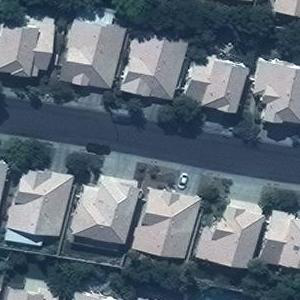

In [101]:
random_file = satellite_images[random.randint(0, len(satellite_images) - 1)]
original_img = Image.open(random_file)
original_img

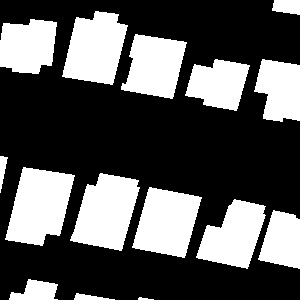

In [102]:
mask_for_file = next(m for m in masks if m.stem == random_file.stem)
Image.open(mask_for_file)

## Reshard images
280k files in single folder slow down ubuntu file explorer

In [80]:
import shutil

In [103]:
sharded_dir = Path("../data/raw/train/images_sharded_v2")
sharded_dir.mkdir(exist_ok=True)
for f in tqdm(satellite_images):
    shard = get_shard(f)
    (sharded_dir / shard).mkdir(exist_ok=True)
    shutil.copy2(f, sharded_dir / shard / f.name)

  0%|          | 0/280741 [00:00<?, ?it/s]

In [112]:
a = set(f.stem for f in Path("/media/marcin/Data/Dev/poc_rooftop_seg/notebooks/neptuneai-mapping-challenge/data/raw/train/for_poc/images_sharded/f3").glob("*.jpg"))
b = set(f.stem for f in Path("/media/marcin/Data/Dev/poc_rooftop_seg/notebooks/neptuneai-mapping-challenge/data/raw/train/for_poc/masks_sharded/f3").glob("*.png"))

In [113]:
a == b

True